In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
import scipy.special as sp
import pickle
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
from sconce.utils import cart2sph, sph2cart, SmoothBootstrap_vMF
from sconce.EucSCMS import KDE, SCMSLog
from sconce.DirSCMS import DirKDE, DirSCMSLog
from sconce.EucSCMS_RayFunc import MS_Ray, SCMSLog_Ray
from sconce.DirSCMS_RayFunc import DirMS_Ray, DirSCMSLog_Ray

import ray

In [3]:
from astropy.io import fits
from astropy.table import Table

# with fits.open('Data/SDSSIV_gal_QSO_dat.fits') as hdulist:
#     SDSS_dat = Table.read(hdulist[1])
# SDSS_dat = SDSS_dat.to_pandas()
# SDSS_dat.head(5)

SDSS_dat = pd.read_csv('Data/SDSSIV_gal_QSO_dat_small.csv')
SDSS_dat.head(5)

,PLATE,MJD,FIBERID,RA,DEC,Z,total_mass
0,266,51602,6,146.96390,-0.545003,0.055988,3.357219e+07
1,266,51602,8,146.60721,-1.240753,0.090633,7.675995e+10
2,266,51602,10,146.72794,-0.556880,0.089337,3.745686e+10
3,266,51602,12,146.59272,-0.760256,0.065024,1.884939e+10
4,266,51602,15,146.94999,-0.592202,0.064777,8.659015e+08


### Redshift slice: $0.06\leq z < 0.065$

We subset the SDSS_IV galaxies on the North Galactic Cap within this redshift slice and apply our directional SCMS (DirSCMS) algorithm with nonparametric and smoothed bootstraps to this dataset.

In [4]:
z_l = 0.06
z_h = 0.065
gal_slice = SDSS_dat[(SDSS_dat.Z >= z_l) & (SDSS_dat.Z < z_h)]
# Focus on the north galactic cap
gal_north = gal_slice[(gal_slice.RA > 100) & (gal_slice.RA < 270) & (gal_slice.DEC > -5) & (gal_slice.DEC < 70)]
X, Y, Z = sph2cart(*gal_north[['RA', 'DEC']].values.T)
gal_north_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
gal_north_ang = gal_north[['RA', 'DEC']].values
print(gal_north_cart.shape)

(26919, 3)


In [5]:
# Bandwidth selection
data = gal_north_cart
d = data.shape[1]
n = data.shape[0]
R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
             ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
bw_Dir = h/4


# Thresholding
d_Dir_dat = DirKDE(gal_north_cart, gal_north_cart, h=bw_Dir)
gal_north_cart_thres = gal_north_cart[d_Dir_dat >= np.std(d_Dir_dat)]
if gal_north_cart_thres.shape[0]/gal_north_cart.shape[0] < 0.8:
    gal_north_cart_thres = gal_north_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
print("Directional Thresholding Ratio: "+str(gal_north_cart_thres.shape[0]/gal_north_cart.shape[0]))

Directional Thresholding Ratio: 0.8000297187859876


In [6]:
nrows, ncols = (76, 171)
lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
xg, yg, zg = sph2cart(lon_m, lat_m)

mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                        yg.reshape(nrows*ncols, 1),
                        zg.reshape(nrows*ncols, 1)), axis=1)

d_m_Dir = DirKDE(mesh1, gal_north_cart_thres, h=bw_Dir)
mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))

Remaining mesh point ratio: 0.8499538319482918


In [7]:
# DMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_north_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-9, max_iter=5000))
DirMS_pts = ray.get(result_ids)
DirMS_pts = np.concatenate(DirMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "wb") as file:
    pickle.dump([bw_Dir, DirMS_pts], file)

2022-07-17 02:37:28,536	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [8]:
# DirSCMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_north_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                                eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "wb") as file:
    pickle.dump([bw_Dir, DirSCMS_pts], file)

2022-07-17 02:39:20,334	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [9]:
with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "rb") as file:
    bw_Dir, DirModes_org = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_org.dat", "rb") as file:
    bw_Dir, DirFila_org = pickle.load(file)

In [10]:
import healpy as hp

def Mask_Filter(gal_RAs, gal_DECs, fil_RAs, fil_DECs, threshold=10, n_neigh=2, final_nside=256):
    nside = 32
    ## hp.nside2npix(nside) is equal to 12*nside**2
    healpix = np.zeros(hp.nside2npix(nside))
    gal_pix = hp.ang2pix(nside, theta=gal_RAs, phi=gal_DECs, lonlat=True)
    pix_ind, obs_cnt = np.unique(gal_pix, return_counts=True)
    healpix[pix_ind] = obs_cnt
    isolon, isolat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))[healpix > threshold], lonlat=True)
    
    # Set up the pixels and find their neighbors after thresholding
    nside_ne = 128
    healpix_ne = np.zeros(hp.nside2npix(nside_ne))
    ne_pix = hp.ang2pix(nside_ne, theta=isolon, phi=isolat, lonlat=True)
    for _ in range(n_neigh):
        ne_pix = np.unique(hp.get_all_neighbours(nside_ne, ne_pix))
    healpix_ne[ne_pix] = 1.
    healpix_ne = hp.ud_grade(healpix_ne, final_nside)
    
    fila_pix = hp.ang2pix(final_nside, theta=fil_RAs, phi=fil_DECs, lonlat=True)
    return healpix_ne, fila_pix

In [11]:
lon_f, lat_f, R = cart2sph(*DirFila_org.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
mask_pix_Dir, fil_pix_Dir = Mask_Filter(gal_RAs=360-gal_north_ang[:,0], gal_DECs=gal_north_ang[:,1], 
                                        fil_RAs=360-lon_f, fil_DECs=lat_f, threshold=2, 
                                        n_neigh=1, final_nside=32)
lon_m, lat_m, R = cart2sph(*DirModes_org.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
mode_pix_Dir = hp.ang2pix(32, theta=360-lon_m, phi=lat_m, lonlat=True)

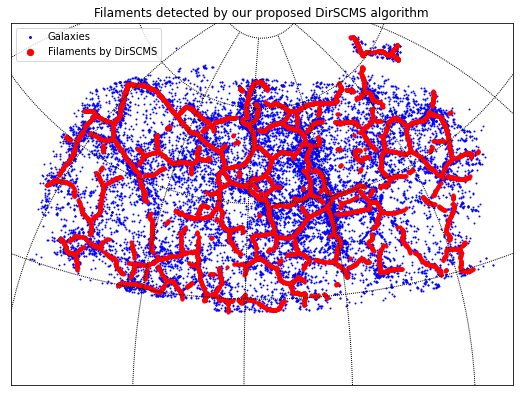

In [12]:
plt.rcParams.update({'font.size': 13})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(9,7))
lon_p = gal_north_ang[:,0]
lat_p = gal_north_ang[:,1]
lon_m, lat_m, R = cart2sph(*DirModes_org[mask_pix_Dir[mode_pix_Dir] != 0].T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
lon_f, lat_f, R = cart2sph(*DirFila_org[mask_pix_Dir[fil_pix_Dir] != 0].T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
# m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_m, y_m = m1(lon_m, lat_m)
x_f, y_f = m1(lon_f, lat_f)
cs = m1.scatter(x_p, y_p, color='blue', marker='o', s=1, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='red', marker='o', s=10, label='Filaments by DirSCMS')
# cs = m1.scatter(x_m, y_m, color='yellow', marker='o', s=15, label='Local Modes')
plt.legend(markerscale=2, loc='upper left')
plt.title('Filaments detected by our proposed DirSCMS algorithm')
plt.show()

### Uncertainty measure with nonparametric bootstrap

In [7]:
with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "rb") as file:
    bw_Dir, DirModes = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_org.dat", "rb") as file:
    bw_Dir, DirFila = pickle.load(file)

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

B = 100  ## Number of bootstrapping times
start = time.time()
np.random.seed(123) 
boot_fila_Dir = []
for b in range(B):
    # Nonparametric Bootstrap
    rand_ind = np.random.choice(range(gal_north_cart.shape[0]), gal_north_cart.shape[0], replace=True)
    boot_dat_cart = gal_north_cart[rand_ind]
    
    # Bandwidth selection
    data = boot_dat_cart
    d = data.shape[1]
    n = data.shape[0]
    R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
    kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
    h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
                 ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
    bw_Dir = h/4
    
    # Thresholding
    d_Dir_dat = DirKDE(boot_dat_cart, boot_dat_cart, h=bw_Dir)
    boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.std(d_Dir_dat)]
    if boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0] < 0.8:
        boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
    print("Directional Thresholding Ratio: "+str(boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0]))
    
    nrows, ncols = (76, 171)
    lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
    xg, yg, zg = sph2cart(lon_m, lat_m)
    
    mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                            yg.reshape(nrows*ncols, 1),
                            zg.reshape(nrows*ncols, 1)), axis=1)

    d_m_Dir = DirKDE(mesh1, boot_dat_cart_thres, h=bw_Dir)
    mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))
    
    # DirSCMS
    ray.init()
    mesh_0 = mesh1_thres
    dataset = boot_dat_cart_thres
    BW = bw_Dir
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, eps=1e-7, 
                                                    max_iter=5000))
    DirSCMS_pts = ray.get(result_ids)
    DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
    ray.shutdown()
    boot_fila_Dir.append(DirSCMS_pts)

with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_B"+str(B)+".dat", "wb") as file:
    pickle.dump(boot_fila_Dir, file)
              
print("Elasped time: "+ str(time.time()-start)+'s.\n')

In [15]:
B = 100
with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_B"+str(B)+".dat", "rb") as file:
    boot_fila_Dir = pickle.load(file)

In [16]:
@ray.remote
def UncMsDir_Fs(fila, boot_fila):
    unc_arr = np.zeros((fila.shape[0], ))
    for i in range(fila.shape[0]):
        pt = fila[i,:]
        dist_sq = np.zeros((len(boot_fila), ))
        for j in range(len(boot_fila)):
            cir_inner = np.dot(boot_fila[j], pt)
            cir_inner[cir_inner > 1] = 1
            cir_inner[cir_inner < -1] = -1
            dist_sq[j] = min(np.arccos(cir_inner)**2)
        unc_arr[i] = np.sqrt(np.mean(dist_sq))
    return unc_arr

In [ ]:
ray.init()
chunksize = 10
fila_data = DirFila
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(UncMsDir_Fs.remote(fila_data[i:(i+chunksize)], boot_fila=boot_fila_Dir))
unc_Dir = ray.get(result_ids)
unc_Dir = np.concatenate(unc_Dir, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +".dat", "wb") as file:
    pickle.dump(unc_Dir, file)

### Uncertainty measure with smoothed bootstrap

In [8]:
with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "rb") as file:
    bw_Dir, DirModes = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_org.dat", "rb") as file:
    bw_Dir, DirFila = pickle.load(file)

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

B = 100  ## Number of bootstrapping times
start = time.time()
np.random.seed(123) 
boot_fila_Dir = []
for b in range(B):
    # Smoothed Bootstrap
    boot_dat_cart = SmoothBootstrap_vMF(gal_north_cart, B=gal_north_cart.shape[0], h=bw_Dir)
    
    # Bandwidth selection
    data = boot_dat_cart
    d = data.shape[1]
    n = data.shape[0]
    R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
    kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
    h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
                 ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
    bw_Dir = h/4
    
    # Thresholding
    d_Dir_dat = DirKDE(boot_dat_cart, boot_dat_cart, h=bw_Dir)
    boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.std(d_Dir_dat)]
    if boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0] < 0.8:
        boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
    print("Directional Thresholding Ratio: "+str(boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0]))
    
    nrows, ncols = (76, 171)
    lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
    xg, yg, zg = sph2cart(lon_m, lat_m)
    
    mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                            yg.reshape(nrows*ncols, 1),
                            zg.reshape(nrows*ncols, 1)), axis=1)

    d_m_Dir = DirKDE(mesh1, boot_dat_cart_thres, h=bw_Dir)
    mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))
    
    # DirSCMS
    ray.init()
    mesh_0 = mesh1_thres
    dataset = boot_dat_cart_thres
    BW = bw_Dir
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, eps=1e-7, 
                                                    max_iter=5000))
    DirSCMS_pts = ray.get(result_ids)
    DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
    ray.shutdown()
    boot_fila_Dir.append(DirSCMS_pts)

with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_B"+str(B)+"_sb.dat", "wb") as file:
    pickle.dump(boot_fila_Dir, file)
              
print("Elasped time: "+ str(time.time()-start)+'s.\n')

In [18]:
B = 100
with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_B"+str(B)+"_sb.dat", "rb") as file:
    boot_fila_Dir = pickle.load(file)

In [ ]:
ray.init()
chunksize = 10
fila_data = DirFila
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(UncMsDir_Fs.remote(fila_data[i:(i+chunksize)], boot_fila=boot_fila_Dir))
unc_Dir = ray.get(result_ids)
unc_Dir = np.concatenate(unc_Dir, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_sb.dat", "wb") as file:
    pickle.dump(unc_Dir, file)

In [19]:
with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +".dat", "rb") as file:
    unc_Dir_nb = pickle.load(file)
    
with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_sb.dat", "rb") as file:
    unc_Dir_sb = pickle.load(file)

In [20]:
lon_f, lat_f, R = cart2sph(*DirFila_org.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
mask_pix_Dir, fil_pix_Dir = Mask_Filter(gal_RAs=360-gal_north_ang[:,0], gal_DECs=gal_north_ang[:,1], 
                                        fil_RAs=360-lon_f, fil_DECs=lat_f, threshold=2, 
                                        n_neigh=1, final_nside=32)
lon_m, lat_m, R = cart2sph(*DirModes_org.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
mode_pix_Dir = hp.ang2pix(32, theta=360-lon_m, phi=lat_m, lonlat=True)

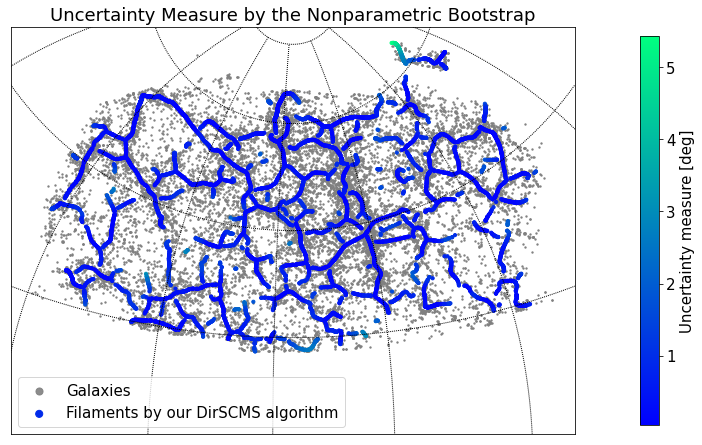

In [21]:
plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(10,7))
lon_p = gal_north_ang[:,0]
lat_p = gal_north_ang[:,1]
lon_m, lat_m, R = cart2sph(*DirModes_org[mask_pix_Dir[mode_pix_Dir] != 0].T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
lon_f, lat_f, R = cart2sph(*DirFila_org[mask_pix_Dir[fil_pix_Dir] != 0].T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
# m1 = Basemap(projection='cyl', llcrnrlat=-10, urcrnrlat=70, llcrnrlon=100, urcrnrlon=270, resolution='l')
m1 = Basemap(width=18000000, height=13000000, resolution='l', projection='stere', lat_ts=50, lat_0=30, lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_f, y_f = m1(lon_f, lat_f)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, c=unc_Dir_nb[mask_pix_Dir[fil_pix_Dir] != 0]*180/np.pi, 
                s=10, cmap='winter', label='Filaments by our DirSCMS algorithm')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.colorbar(label='Uncertainty measure [deg]', fraction=0.03, pad=0.1)
plt.title('Uncertainty Measure by the Nonparametric Bootstrap')
plt.tight_layout()
plt.savefig('./Figures/nonpar_boot_fila.jpg', bbox_inches="tight", dpi=150)
# plt.show()

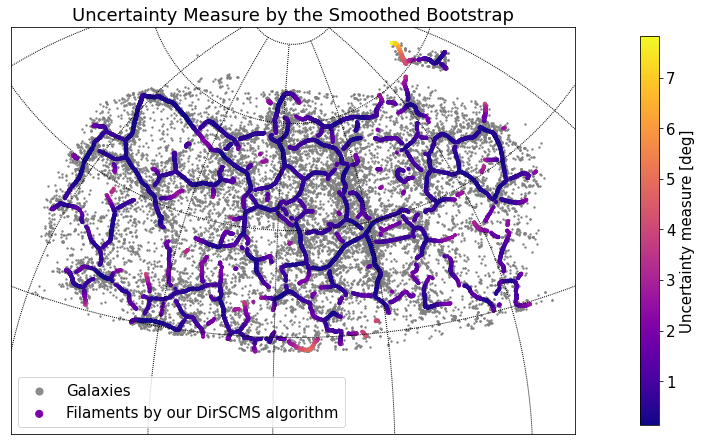

In [22]:
plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(10,7))
lon_p = gal_north_ang[:,0]
lat_p = gal_north_ang[:,1]
lon_m, lat_m, R = cart2sph(*DirModes_org[mask_pix_Dir[mode_pix_Dir] != 0].T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
lon_f, lat_f, R = cart2sph(*DirFila_org[mask_pix_Dir[fil_pix_Dir] != 0].T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
# m1 = Basemap(projection='cyl', llcrnrlat=-10, urcrnrlat=70, llcrnrlon=100, urcrnrlon=270, resolution='l')
m1 = Basemap(width=18000000, height=13000000, resolution='l', projection='stere', lat_ts=50, lat_0=30, lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_f, y_f = m1(lon_f, lat_f)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, c=unc_Dir_sb[mask_pix_Dir[fil_pix_Dir] != 0]*180/np.pi, 
                s=10, cmap='plasma', label='Filaments by our DirSCMS algorithm')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.colorbar(label='Uncertainty measure [deg]', fraction=0.03, pad=0.1)
plt.title('Uncertainty Measure by the Smoothed Bootstrap')
plt.tight_layout()
plt.savefig('./Figures/smoothed_boot_fila.jpg', bbox_inches="tight", dpi=150)
# plt.show()

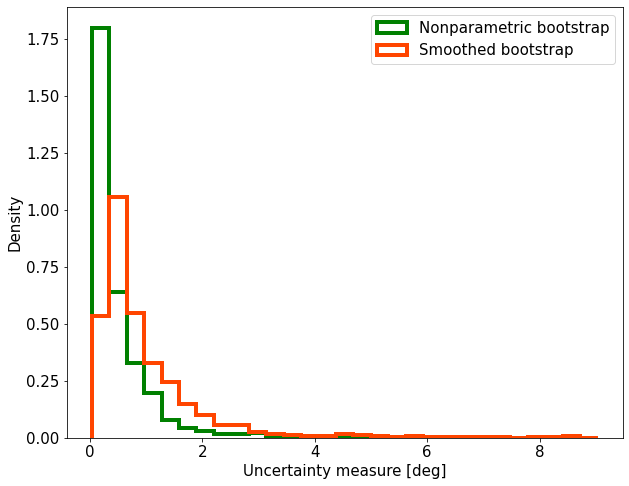

In [23]:
bins_ed = np.linspace(min(unc_Dir_nb*180/np.pi), max(unc_Dir_sb*180/np.pi), 30)

plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
plt.figure(figsize=(9,7))
## Histogram comparisons
plt.hist(unc_Dir_nb*180/np.pi, bins=bins_ed, histtype='step', density=True, fill=False, color='green', 
         linewidth=4, label='Nonparametric bootstrap')
plt.hist(unc_Dir_sb*180/np.pi, bins=bins_ed, histtype='step', density=True, fill=False, color='orangered', 
         linewidth=4, label='Smoothed bootstrap')
plt.legend()
plt.xlabel('Uncertainty measure [deg]')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('./Figures/boot_hist.pdf')
# plt.show()

In [26]:
from sklearn.linear_model import LinearRegression

unc_Dir_nb1 = unc_Dir_nb*180/np.pi
unc_Dir_sb1 = unc_Dir_sb*180/np.pi

boot_reg = LinearRegression().fit(unc_Dir_nb1.reshape(-1,1), unc_Dir_sb1)

In [27]:
x_lin = np.linspace(0, max(unc_Dir_nb1), 100)

n = len(unc_Dir_nb1)
y_std = np.sqrt(sum((unc_Dir_sb1 - boot_reg.predict(unc_Dir_nb1.reshape(-1,1)))**2) / (n-2))

boot_unc_pts = np.vstack((unc_Dir_nb1, unc_Dir_sb1)).T
d_pts = KDE(boot_unc_pts, boot_unc_pts)

The current bandwidth is 0.18435382822500568.



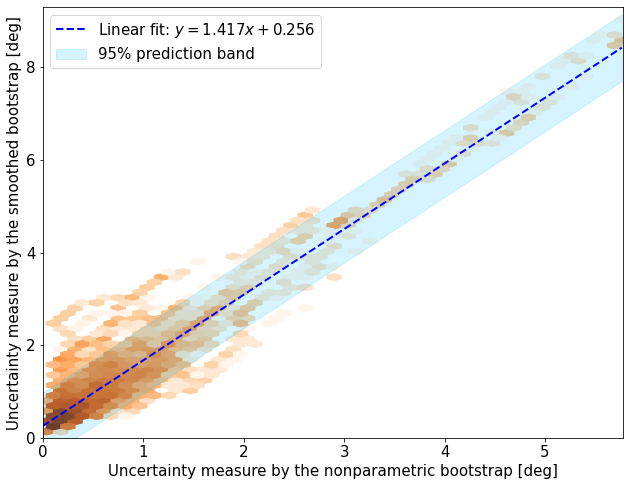

In [28]:
plt.figure(figsize=(9,7))
# plt.scatter(unc_Dir_nb1, unc_Dir_sb1, c=(d_pts)**(1/20), cmap='Oranges', alpha=1)
plt.hexbin(unc_Dir_nb1, unc_Dir_sb1, gridsize=(40,40), cmap='Oranges', bins='log', alpha=1)
# plt.axline((5, 5*boot_reg.coef_[0]+boot_reg.intercept_), slope=boot_reg.coef_[0], 
#            label='Linear fit: $y='+str(round(boot_reg.coef_[0], 3))+'x'+str(round(boot_reg.intercept_, 3))+'$', 
#            color='red', linewidth=5)
plt.plot(x_lin, boot_reg.predict(x_lin.reshape(-1,1)), 
         label='Linear fit: $y='+str(round(boot_reg.coef_[0], 3))+'x+'+str(round(boot_reg.intercept_, 3))+'$', 
         color='blue', linewidth=2, linestyle='dashed')

plt.fill_between(x_lin, boot_reg.predict(x_lin.reshape(-1,1)) + y_std*stats.t.ppf(0.975, df=n-2) * np.sqrt(1+1/n + (x_lin - np.mean(unc_Dir_nb1))**2/(np.sum((unc_Dir_nb1 - np.mean(unc_Dir_nb1))**2))),
             boot_reg.predict(x_lin.reshape(-1,1)) - y_std*stats.t.ppf(0.975, df=n-2) * np.sqrt(1+1/n + (x_lin - np.mean(unc_Dir_nb1))**2/(np.sum((unc_Dir_nb1 - np.mean(unc_Dir_nb1))**2))), 
             alpha=0.16, color='deepskyblue', label='95% prediction band')

# plt.plot(x_lin, boot_reg.predict(x_lin.reshape(-1,1)) + y_std*stats.t.ppf(0.975, df=n-2) * np.sqrt(1+1/n + (x_lin - np.mean(unc_Dir_nb1))**2/(np.sum((unc_Dir_nb1 - np.mean(unc_Dir_nb1))**2))), 
#          linestyle='--', color='deepskyblue', linewidth=3, alpha=0.6)
# plt.plot(x_lin, boot_reg.predict(x_lin.reshape(-1,1)) - y_std*stats.t.ppf(0.975, df=n-2) * np.sqrt(1+1/n + (x_lin - np.mean(unc_Dir_nb1))**2/(np.sum((unc_Dir_nb1 - np.mean(unc_Dir_nb1))**2))), 
#          linestyle='--', color='deepskyblue', linewidth=3, alpha=0.6)
plt.legend()
plt.xlabel('Uncertainty measure by the nonparametric bootstrap [deg]')
plt.ylabel('Uncertainty measure by the smoothed bootstrap [deg]')
plt.xlim(0, max(unc_Dir_nb1)+0.01)
plt.ylim(0, 9.3)
plt.tight_layout()
plt.savefig('./Figures/boot_scatter.pdf')
# plt.show()

In [29]:
from scipy import stats

print(stats.pearsonr(unc_Dir_nb, unc_Dir_sb))
print(stats.spearmanr(unc_Dir_nb, unc_Dir_sb))

(0.9363956481011422, 0.0)
SpearmanrResult(correlation=0.8374701538377279, pvalue=0.0)
